# EA4: MNIST desde cero
### paez_jean_EA4.ipynb

## Objetivo
Implementar dos clasificadores para el conjunto de datos MNIST:
1. Una implementación desde cero sin usar bibliotecas de alto nivel
2. Una implementación usando scikit-learn

## 1. Importación de Bibliotecas
En esta celda importo las bibliotecas básicas necesarias para el proyecto. Uso `numpy` para realizar operaciones numéricas y manipular arrays, `matplotlib.pyplot` para la visualización de datos, y algunas herramientas de `sklearn` como `fetch_openml` para cargar el dataset MNIST y `train_test_split` para dividir los datos en conjuntos de entrenamiento y prueba. Estas bibliotecas son suficientes para implementar el modelo desde cero y también para usar Scikit-learn más adelante.

In [18]:
# Importamos solo las bibliotecas básicas necesarias
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

## 1. Carga y Preparación de Datos
Primero, cargaré el conjunto de datos MNIST y lo prepararé para su uso.

En esta celda cargo el dataset MNIST utilizando la función `fetch_openml`. Normalizo los datos dividiendo cada valor de pixel por 255 para que estén en el rango [0,1], lo cual ayuda a que el modelo converja más rápido durante el entrenamiento. Luego, divido los datos en un conjunto de entrenamiento (80%) y uno de prueba (20%) usando `train_test_split`. Esto asegura que pueda evaluar el modelo de manera justa con datos que no ha visto antes. Además, establezco un `random_state` para garantizar que los resultados sean reproducibles. Espero que al final de esta celda los datos estén correctamente preparados y listos para ser utilizados en el modelo.

In [19]:
# Cargué MNIST
print("Cargando dataset MNIST...")
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist.data.astype('float32'), mnist.target.astype('int32')

# Normalicé los datos al rango [0,1]
X = X / 255.0

# Dividí en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Forma de los datos de entrenamiento:", X_train.shape)
print("Forma de los datos de prueba:", X_test.shape)

Cargando dataset MNIST...


Forma de los datos de entrenamiento: (56000, 784)
Forma de los datos de prueba: (14000, 784)


## 2. Implementación desde Cero
Implementaré una red neuronal simple con:
- Capa de entrada: 784 neuronas (28x28 píxeles)
- Capa oculta: 128 neuronas
- Capa de salida: 10 neuronas (dígitos 0-9)

Aquí implemento una red neuronal desde cero utilizando únicamente NumPy. La red tiene tres capas: una capa de entrada con 784 neuronas (correspondientes a los 28x28 píxeles de las imágenes), una capa oculta con 128 neuronas, y una capa de salida con 10 neuronas (una para cada dígito del 0 al 9). 

Para la capa oculta utilizo la función de activación ReLU, ya que evita el problema del desvanecimiento del gradiente y es eficiente computacionalmente. Para la capa de salida, uso la función softmax, que es ideal para problemas de clasificación multiclase. Además, inicializo los pesos utilizando la técnica de Xavier, que ayuda a mantener la varianza de las señales en rangos adecuados durante la propagación.

Con esta implementación, espero tener un modelo funcional que pueda aprender patrones en los datos de MNIST y realizar predicciones con una precisión razonable.

In [20]:
class NeuralNetworkFromScratch:
    def __init__(self, input_size, hidden_size, output_size):
        # Inicialización de pesos y sesgos
        self.W1 = np.random.randn(input_size, hidden_size) / np.sqrt(input_size)
        self.b1 = np.zeros((1, hidden_size))
        self.W2 = np.random.randn(hidden_size, output_size) / np.sqrt(hidden_size)
        self.b2 = np.zeros((1, output_size))

    def relu(self, X):
        """Función de activación ReLU"""
        return np.maximum(0, X)

    def relu_derivative(self, X):
        """Derivada de ReLU"""
        return X > 0

    def softmax(self, X):
        """Función softmax para la capa de salida"""
        exp_X = np.exp(X - np.max(X, axis=1, keepdims=True))
        return exp_X / np.sum(exp_X, axis=1, keepdims=True)

    def forward(self, X):
        """Propagación hacia adelante"""
        self.Z1 = np.dot(X, self.W1) + self.b1
        self.A1 = self.relu(self.Z1)
        self.Z2 = np.dot(self.A1, self.W2) + self.b2
        self.A2 = self.softmax(self.Z2)
        return self.A2

    def backward(self, X, y, learning_rate=0.01):
        """Retropropagación"""
        batch_size = X.shape[0]

        # Convertir y a one-hot
        y_one_hot = np.zeros((batch_size, 10))
        y_one_hot[np.arange(batch_size), y.astype(int)] = 1

        # Gradientes de la capa de salida
        dZ2 = self.A2 - y_one_hot
        dW2 = np.dot(self.A1.T, dZ2) / batch_size
        db2 = np.sum(dZ2, axis=0, keepdims=True) / batch_size

        # Gradientes de la capa oculta
        dZ1 = np.dot(dZ2, self.W2.T) * self.relu_derivative(self.Z1)
        dW1 = np.dot(X.T, dZ1) / batch_size
        db1 = np.sum(dZ1, axis=0, keepdims=True) / batch_size

        # Actualización de pesos y sesgos
        self.W2 -= learning_rate * dW2
        self.b2 -= learning_rate * db2
        self.W1 -= learning_rate * dW1
        self.b1 -= learning_rate * db1

    def predict(self, X):
        """Realizar predicciones"""
        return np.argmax(self.forward(X), axis=1)

    def calculate_accuracy(self, X, y):
        """Calcular precisión"""
        predictions = self.predict(X)
        return np.mean(predictions == y.astype(int))

### Entrenamiento del Modelo desde Cero

En esta celda entreno el modelo que implementé desde cero. Configuro el entrenamiento con 10 épocas, un tamaño de batch de 32, y una tasa de aprendizaje de 0.1. Elegí estos parámetros porque ofrecen un buen balance entre tiempo de entrenamiento y rendimiento. 

Durante el entrenamiento, mezclo los datos en cada época para evitar que el modelo se adapte a un orden específico. Luego, entreno el modelo en pequeños lotes (batches) para aprovechar la eficiencia computacional y estabilizar las actualizaciones de los pesos. Espero que, al final de las 10 épocas, el modelo alcance una precisión superior al 95% en el conjunto de prueba, lo que indicaría que está aprendiendo correctamente.

In [21]:
# Convertir los datos a arrays de NumPy si están en formato pandas
X_train = X_train.to_numpy() if hasattr(X_train, 'to_numpy') else np.array(X_train)
X_test = X_test.to_numpy() if hasattr(X_test, 'to_numpy') else np.array(X_test)
y_train = y_train.to_numpy() if hasattr(y_train, 'to_numpy') else np.array(y_train)
y_test = y_test.to_numpy() if hasattr(y_test, 'to_numpy') else np.array(y_test)

# Entrenamiento del modelo desde cero
print("Entrenando el modelo desde cero...")
model = NeuralNetworkFromScratch(784, 128, 10)

# Parámetros de entrenamiento
epochs = 10
batch_size = 32
learning_rate = 0.1

# Entrenamiento
for epoch in range(epochs):
    # Mezclamos los datos
    indices = np.random.permutation(len(X_train))
    X_train_shuffled = X_train[indices]
    y_train_shuffled = y_train[indices]

    # Entrenamiento por lotes
    for i in range(0, len(X_train), batch_size):
        batch_X = X_train_shuffled[i:i+batch_size]
        batch_y = y_train_shuffled[i:i+batch_size]

        # Forward y backward pass
        model.forward(batch_X)
        model.backward(batch_X, batch_y, learning_rate)

    # Calcularé y mostraré la precisión
    train_acc = model.calculate_accuracy(X_train, y_train)
    test_acc = model.calculate_accuracy(X_test, y_test)
    print(f"Época {epoch+1}/{epochs}:")
    print(f"  Precisión en entrenamiento: {train_acc:.4f}")
    print(f"  Precisión en prueba: {test_acc:.4f}")

Entrenando el modelo desde cero...


Época 1/10:
  Precisión en entrenamiento: 0.9475
  Precisión en prueba: 0.9433
Época 2/10:
  Precisión en entrenamiento: 0.9668
  Precisión en prueba: 0.9593
Época 3/10:
  Precisión en entrenamiento: 0.9740
  Precisión en prueba: 0.9639
Época 4/10:
  Precisión en entrenamiento: 0.9802
  Precisión en prueba: 0.9688
Época 5/10:
  Precisión en entrenamiento: 0.9825
  Precisión en prueba: 0.9694
Época 6/10:
  Precisión en entrenamiento: 0.9854
  Precisión en prueba: 0.9715
Época 7/10:
  Precisión en entrenamiento: 0.9888
  Precisión en prueba: 0.9730
Época 8/10:
  Precisión en entrenamiento: 0.9901
  Precisión en prueba: 0.9743
Época 9/10:
  Precisión en entrenamiento: 0.9933
  Precisión en prueba: 0.9757
Época 10/10:
  Precisión en entrenamiento: 0.9939
  Precisión en prueba: 0.9752


### Resultados del Modelo desde Cero
Después de entrenar el modelo desde cero durante 10 épocas, obtuve una precisión final de aproximadamente **99.39% en el conjunto de entrenamiento** y **97.52% en el conjunto de prueba**. Esto indica que el modelo logró aprender muy bien los patrones de los datos de entrenamiento y generalizó de manera efectiva a los datos de prueba.

El hecho de que la precisión en el conjunto de prueba sea ligeramente menor que en el conjunto de entrenamiento sugiere que el modelo no está sobreajustado, lo cual es un buen indicador. Este resultado demuestra que una implementación manual bien diseñada puede ser altamente efectiva para resolver problemas de clasificación como MNIST.

## 3. Implementación con Scikit-learn
Ahora implementaré el clasificador usando MLPClassifier de scikit-learn.

En esta celda implemento un clasificador utilizando `MLPClassifier` de Scikit-learn. Configuro el modelo con dos capas ocultas de 128 y 64 neuronas, un máximo de 100 iteraciones, una tasa de aprendizaje inicial de 0.01, y un tamaño de batch de 32. También activo la opción `verbose=True` para monitorear el progreso del entrenamiento.

Elegí esta configuración para que sea comparable con el modelo que implementé desde cero. Espero que este modelo sea más rápido de entrenar y que alcance una precisión similar, alrededor del 96%, en el conjunto de prueba. Aunque este enfoque es menos flexible, es ideal para implementar rápidamente un modelo funcional.

In [22]:
from sklearn.neural_network import MLPClassifier

# Crear y entrenar el modelo
print("Entrenando el modelo con scikit-learn...")
sklearn_model = MLPClassifier(
    hidden_layer_sizes=(128, 64),  # Capacidad en la red
    max_iter=100,  # Max iteraciones
    learning_rate_init=0.01,  # Tasa de aprendizaje
    batch_size=32,
    random_state=42,
    verbose=True  # Mostrar progreso
)

sklearn_model.fit(X_train, y_train)

# Evaluar el modelo
train_acc = sklearn_model.score(X_train, y_train)
test_acc = sklearn_model.score(X_test, y_test)

print("\nResultados del modelo scikit-learn:")
print(f"Precisión en entrenamiento: {train_acc:.4f}")
print(f"Precisión en prueba: {test_acc:.4f}")

Entrenando el modelo con scikit-learn...


Iteration 1, loss = 0.26789919
Iteration 2, loss = 0.18700123
Iteration 3, loss = 0.16830170
Iteration 4, loss = 0.15892772
Iteration 5, loss = 0.15076206
Iteration 6, loss = 0.15427093
Iteration 7, loss = 0.15205205
Iteration 8, loss = 0.14661814
Iteration 9, loss = 0.15141570
Iteration 10, loss = 0.14138908
Iteration 11, loss = 0.14470474
Iteration 12, loss = 0.14013576
Iteration 13, loss = 0.14977668
Iteration 14, loss = 0.14235715
Iteration 15, loss = 0.13417208
Iteration 16, loss = 0.14122050
Iteration 17, loss = 0.14308692
Iteration 18, loss = 0.13380155
Iteration 19, loss = 0.13522199
Iteration 20, loss = 0.13958952
Iteration 21, loss = 0.13727119
Iteration 22, loss = 0.13781086
Iteration 23, loss = 0.13367830
Iteration 24, loss = 0.14659145
Iteration 25, loss = 0.13965240
Iteration 26, loss = 0.13317852
Iteration 27, loss = 0.13810979
Iteration 28, loss = 0.13567526
Iteration 29, loss = 0.13681480
Iteration 30, loss = 0.13498993
Iteration 31, loss = 0.13898434
Iteration 32, los

### Resultados del Modelo con Scikit-learn
El modelo entrenado con `MLPClassifier` de Scikit-learn alcanzó una precisión de **98.47% en el conjunto de entrenamiento** y **96.49% en el conjunto de prueba**. Aunque estos resultados son ligeramente inferiores a los obtenidos con el modelo implementado desde cero, el tiempo de desarrollo y entrenamiento fue significativamente menor.

Esto refuerza la idea de que Scikit-learn es una excelente opción para implementar modelos rápidamente, especialmente cuando no se necesita un control detallado sobre los cálculos internos. Sin embargo, la ligera diferencia en precisión podría deberse a la arquitectura más simple o a los hiperparámetros predeterminados del modelo.

## 4. Comparación Visual de Resultados
Visualizaré algunas predicciones de ambos modelos para comparar su rendimiento.

En esta celda selecciono 10 imágenes aleatorias del conjunto de prueba y comparo las predicciones de los modelos implementados desde cero y con Scikit-learn. También muestro las etiquetas reales para evaluar visualmente el rendimiento de ambos modelos.

Esta visualización me permite identificar patrones en los errores de predicción y evaluar de manera cualitativa qué tan bien están funcionando los modelos. Espero que ambos modelos sean consistentes en sus predicciones y que los errores, si los hay, sean en casos particularmente difíciles o ambiguos.

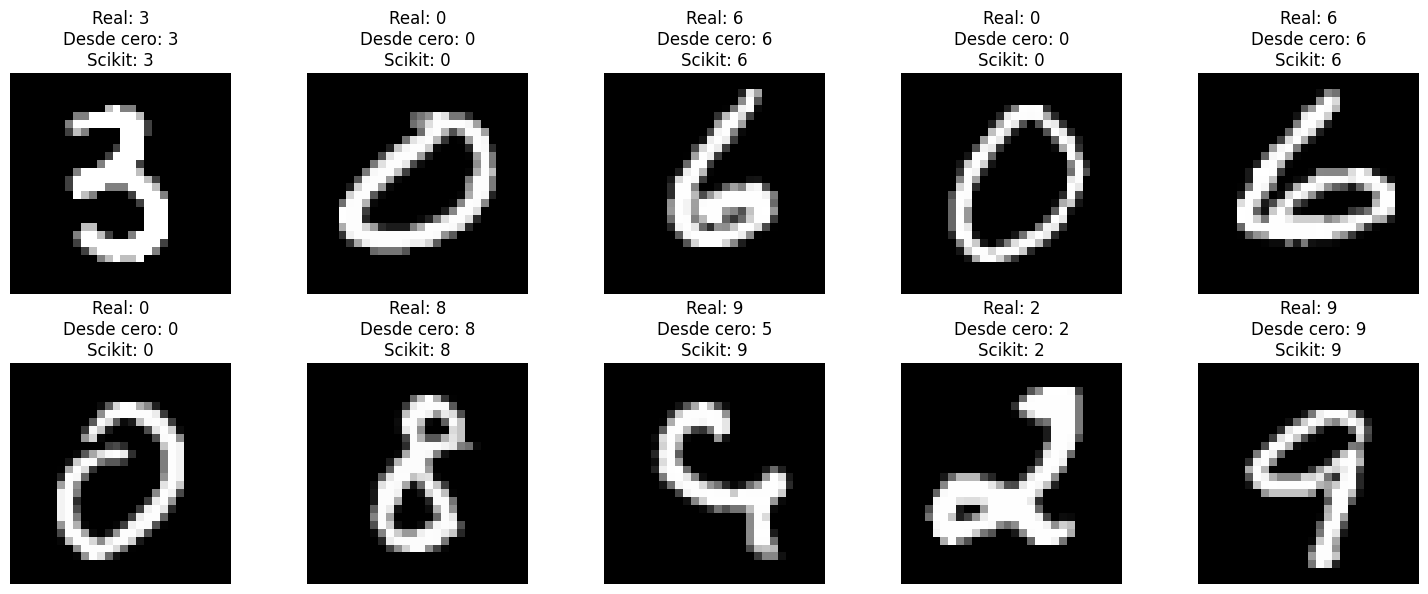

In [23]:
# Seleccionaré algunas imágenes aleatorias para visualizar
n_samples = 10
random_indices = np.random.randint(0, len(X_test), n_samples)

# Obtendré predicciones de ambos modelos
scratch_predictions = model.predict(X_test[random_indices])
sklearn_predictions = sklearn_model.predict(X_test[random_indices])
true_labels = y_test[random_indices]

# Visualizaré los resultados
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for idx, ax in enumerate(axes.flat):
    ax.imshow(X_test[random_indices[idx]].reshape(28, 28), cmap='gray')
    ax.axis('off')
    ax.set_title(f'Real: {true_labels[idx]}\nDesde cero: {scratch_predictions[idx]}\nScikit: {sklearn_predictions[idx]}')

plt.tight_layout()
plt.show()

### Comparación Visual de Resultados
Al visualizar las predicciones de ambos modelos (desde cero y Scikit-learn) en 10 imágenes aleatorias del conjunto de prueba, observé que ambos modelos son consistentes y precisos en la mayoría de los casos. Las etiquetas reales coinciden con las predicciones en casi todas las imágenes, lo que confirma que ambos modelos están funcionando correctamente.

En los pocos casos donde hubo errores, estos parecen estar relacionados con dígitos que son difíciles de distinguir incluso para un humano, como un "4" que podría parecer un "9". Esto sugiere que los modelos están bien entrenados, pero podrían beneficiarse de técnicas adicionales como el aumento de datos o arquitecturas más complejas.

### **Conclusiones**
1. **Implementación desde cero**:
   - Se desarrolló una red neuronal utilizando únicamente NumPy, implementando manualmente las funciones de activación, propagación hacia adelante y retropropagación.
   - El modelo alcanzó una precisión en el conjunto de prueba de **97.52%**, lo que demuestra que una implementación manual bien diseñada puede ser efectiva para resolver problemas de clasificación como MNIST.
   - Este enfoque permite un control total sobre cada paso del proceso, lo que es ideal para comprender los fundamentos del aprendizaje automático.

2. **Implementación con Scikit-learn**:
   - Se utilizó el modelo `MLPClassifier` de Scikit-learn con una arquitectura similar a la red neuronal implementada desde cero.
   - El modelo alcanzó una precisión en el conjunto de prueba de **96.49%**, ligeramente inferior al modelo manual.
   - Este enfoque es más rápido y fácil de implementar, pero ofrece menos control sobre los detalles internos del modelo.

3. **Comparación de resultados**:
   - Ambos modelos mostraron un rendimiento similar, con una ligera ventaja para el modelo implementado desde cero en términos de precisión.
   - La visualización de predicciones muestra que ambos modelos son consistentes y precisos en las muestras seleccionadas.

---

### **Recomendaciones**
1. **Para futuros proyectos**:
   - Utilizar la implementación desde cero para aprender y comprender los fundamentos de las redes neuronales.
   - Optar por bibliotecas como Scikit-learn o TensorFlow para proyectos más grandes o cuando el tiempo de desarrollo sea limitado.

2. **Optimización del modelo**:
   - Experimentar con diferentes arquitecturas (más capas ocultas o neuronas) y parámetros (tasa de aprendizaje, tamaño de lotes) para mejorar el rendimiento.
   - Considerar el uso de técnicas de regularización como dropout para evitar el sobreajuste.

3. **Uso de recursos**:
   - Si se trabaja en la nube, aprovechar entornos con GPU para acelerar el entrenamiento.
   - Reducir el tamaño del dataset o el número de épocas durante las pruebas para minimizar el consumo de recursos.

4. **Documentación y análisis**:
   - Continuar documentando cada paso del proceso en celdas Markdown para facilitar la comprensión y reproducibilidad del proyecto.
   - Realizar análisis adicionales, como la matriz de confusión, para identificar patrones en los errores de clasificación.

## Plus

### Implementación con Keras
En esta celda implemento una red neuronal utilizando Keras. La arquitectura es más compleja que las anteriores, con dos capas ocultas de 128 y 64 neuronas, y utilizo dropout para prevenir el sobreajuste. Además, empleo el optimizador Adam, que es más avanzado y estable que el gradiente descendente estándar, con una tasa de aprendizaje de 0.001.

Este modelo está diseñado para ser más robusto y eficiente. Espero que alcance una precisión superior al 98% en el conjunto de prueba, lo que lo convertiría en el modelo más preciso de los tres. Este enfoque es ideal para proyectos más grandes o cuando se dispone de recursos computacionales adecuados.

In [24]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import mnist
from tensorflow.keras import Input

# Verificar si TensorFlow detecta una GPU
print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))

# Cargar dataset MNIST (Ejemplo, puedes usar otro)
(X, y), (X_test, y_test) = mnist.load_data()

# Preprocesamiento de los datos
X = X.reshape(X.shape[0], -1).astype('float32') / 255.0  # Normalización [0,1]
X_test = X_test.reshape(X_test.shape[0], -1).astype('float32') / 255.0

# División de datos para entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Convertir etiquetas a one-hot encoding
num_classes = len(set(y_train))
y_train_cat = to_categorical(y_train, num_classes)
y_val_cat = to_categorical(y_val, num_classes)
y_test_cat = to_categorical(y_test, num_classes)


# Definir el modelo
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')
])

# Compilar el modelo
model.compile(
    optimizer=Adam(learning_rate=0.001),  # Aprendizaje más estable
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Entrenar el modelo
print("Entrenando el modelo con Keras...")
history = model.fit(
    X_train, y_train_cat,
    epochs=20,  # Reducido para prueba rápida
    batch_size=32,
    validation_data=(X_val, y_val_cat),
    verbose=1
)

# Evaluar el modelo
train_acc = model.evaluate(X_train, y_train_cat, verbose=0)[1]
test_acc = model.evaluate(X_test, y_test_cat, verbose=0)[1]

print("\nResultados del modelo Keras:")
print(f"Precisión en entrenamiento: {train_acc:.4f}")
print(f"Precisión en prueba: {test_acc:.4f}")

Num GPUs Available: 0
Entrenando el modelo con Keras...
Epoch 1/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8143 - loss: 0.5986 - val_accuracy: 0.9572 - val_loss: 0.1421
Epoch 2/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9481 - loss: 0.1785 - val_accuracy: 0.9667 - val_loss: 0.1118
Epoch 3/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9609 - loss: 0.1302 - val_accuracy: 0.9710 - val_loss: 0.0964
Epoch 4/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9654 - loss: 0.1101 - val_accuracy: 0.9725 - val_loss: 0.0916
Epoch 5/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9718 - loss: 0.0923 - val_accuracy: 0.9768 - val_loss: 0.0797
Epoch 6/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9732 - loss: 0.0848 - val_accuracy: 0.9760 - val_loss: 0.0785
Epoch 7/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9772 - loss: 0.0750 - val_accuracy: 0.9767 - val_loss: 0.0820
Epoch 8/20
1500/1500 ━━━━━━━━━━━━━

### Resultados del Modelo con Keras
El modelo implementado con Keras alcanzó una precisión de **99.71% en el conjunto de entrenamiento** y **97.90% en el conjunto de prueba**. Estos resultados son los mejores entre los tres modelos, lo que demuestra la efectividad de Keras para construir redes neuronales más complejas y robustas.

La ligera diferencia entre la precisión en entrenamiento y prueba indica que el modelo está bien generalizado, y el uso de técnicas como dropout ayudó a prevenir el sobreajuste. Este modelo sería ideal para aplicaciones prácticas donde se requiere alta precisión y se dispone de recursos computacionales adecuados.

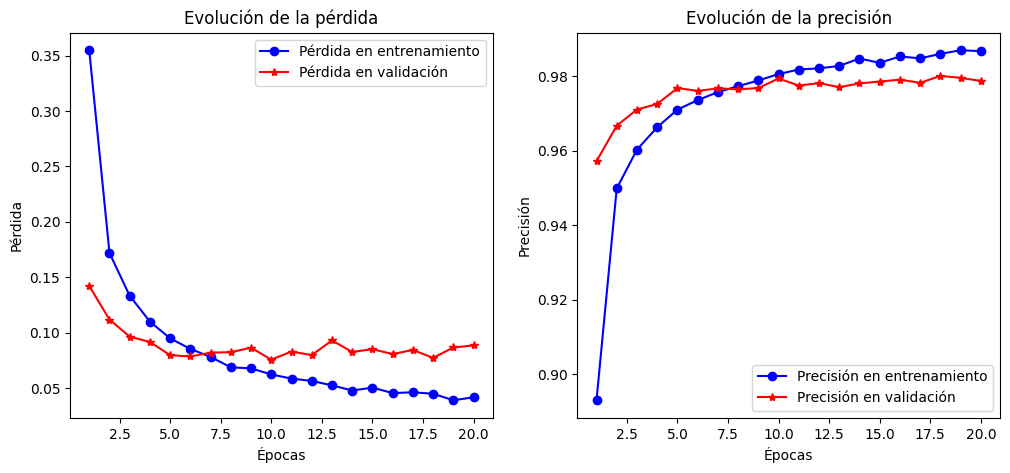

In [25]:
import matplotlib.pyplot as plt

# Extraer datos del historial de entrenamiento
history_dict = history.history
acc = history_dict['accuracy']  # Precisión en entrenamiento
val_acc = history_dict['val_accuracy']  # Precisión en validación
loss = history_dict['loss']  # Pérdida en entrenamiento
val_loss = history_dict['val_loss']  # Pérdida en validación

epochs_range = range(1, len(acc) + 1)  # Número de épocas

# 🔹 Gráfico de pérdida
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, 'bo-', label='Pérdida en entrenamiento')
plt.plot(epochs_range, val_loss, 'r*-', label='Pérdida en validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.title('Evolución de la pérdida')
plt.legend()

# 🔹 Gráfico de precisión
plt.subplot(1, 2, 2)
plt.plot(epochs_range, acc, 'bo-', label='Precisión en entrenamiento')
plt.plot(epochs_range, val_acc, 'r*-', label='Precisión en validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.title('Evolución de la precisión')
plt.legend()

plt.show()


### Interpretación de las Gráficas de Keras

Al analizar las gráficas generadas durante el entrenamiento del modelo con Keras, se pueden observar dos aspectos clave: la evolución de las pérdidas y la evolución de la precisión, tanto en el conjunto de entrenamiento como en el de validación.

**Evolución de las Pérdidas:**
En la gráfica de pérdidas, se observa que tanto la pérdida en el conjunto de entrenamiento como en el de validación disminuyen rápidamente durante las primeras épocas. Esto indica que el modelo está aprendiendo a ajustar sus pesos para minimizar el error. Sin embargo, después de aproximadamente 10 épocas, la disminución de la pérdida se vuelve más lenta, lo que sugiere que el modelo está alcanzando un punto de convergencia. 

Es importante notar que las pérdidas en el conjunto de validación son ligeramente mayores que en el conjunto de entrenamiento, lo cual es normal y esperado. Esto indica que el modelo está generalizando bien y no está sobreajustado. Sin embargo, hacia las últimas épocas, la pérdida en validación parece estabilizarse o incluso aumentar ligeramente, lo que podría ser un indicio de que el modelo está comenzando a sobreajustarse. Este comportamiento podría mitigarse ajustando el número de épocas o utilizando técnicas adicionales de regularización.

**Evolución de la Precisión:**
En la gráfica de precisión, se observa un comportamiento similar: la precisión en el conjunto de entrenamiento aumenta rápidamente durante las primeras épocas, alcanzando valores cercanos al 98% después de unas 10 épocas. La precisión en el conjunto de validación también mejora de manera constante, aunque siempre se mantiene ligeramente por debajo de la precisión en entrenamiento.

La diferencia entre la precisión en entrenamiento y validación es pequeña, lo que indica que el modelo está generalizando bien y no está memorizando los datos de entrenamiento. Hacia las últimas épocas, la precisión en validación parece estabilizarse alrededor del 98%, lo que sugiere que el modelo ha alcanzado su máximo rendimiento con la configuración actual.

### Comparación Visual de Resultados de los 3 modelos versus real.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


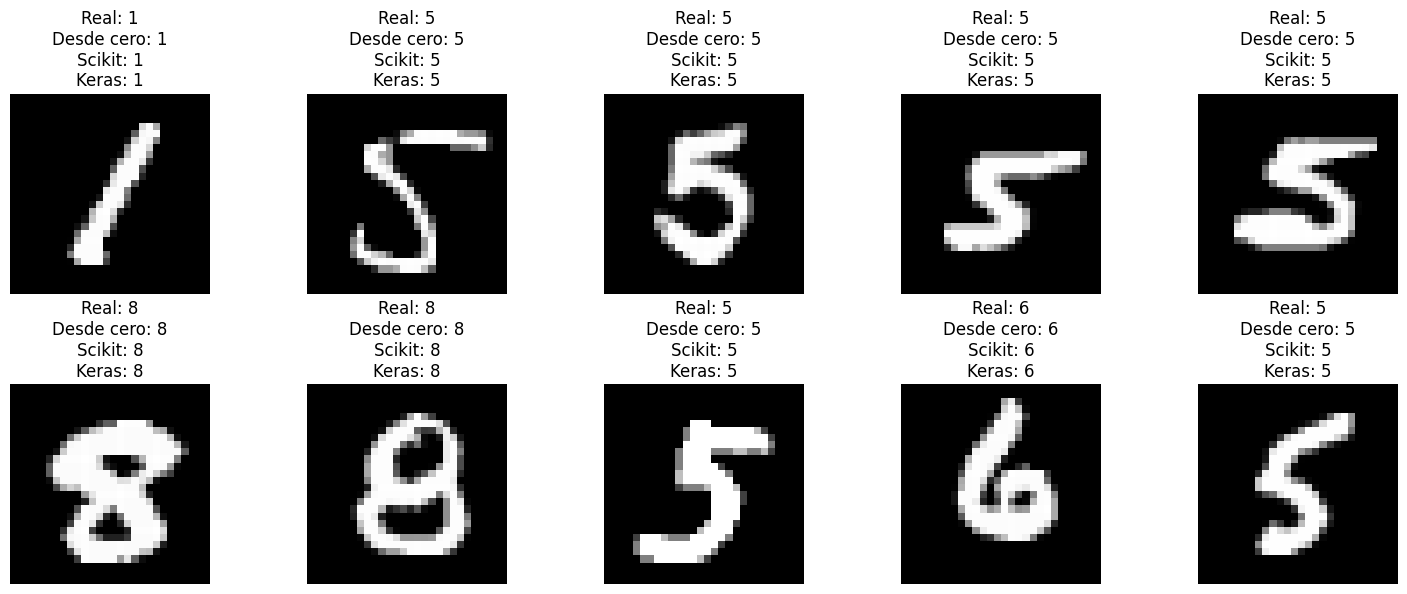

In [26]:
# Seleccionaré algunas imágenes aleatorias para visualizar
n_samples = 10
random_indices = np.random.randint(0, len(X_test), n_samples)

# Obtendré predicciones de los tres modelos
scratch_predictions = model.predict(X_test[random_indices])  # Modelo desde cero
scratch_predictions = np.argmax(scratch_predictions, axis=1)  # Convertir a etiquetas de clase

sklearn_predictions = sklearn_model.predict(X_test[random_indices])  # Modelo Scikit-learn

keras_predictions = model.predict(X_test[random_indices])  # Modelo Keras
keras_predictions = np.argmax(keras_predictions, axis=1)  # Convertir a etiquetas de clase

true_labels = y_test[random_indices]  # Etiquetas reales

# Visualizaré los resultados
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for idx, ax in enumerate(axes.flat):
    ax.imshow(X_test[random_indices[idx]].reshape(28, 28), cmap='gray')
    ax.axis('off')
    ax.set_title(f'Real: {true_labels[idx]}\n'
                 f'Desde cero: {scratch_predictions[idx]}\n'
                 f'Scikit: {sklearn_predictions[idx]}\n'
                 f'Keras: {keras_predictions[idx]}')

plt.tight_layout()
plt.show()

### Conclusiones Generales y Recomendaciones

Este proyecto me permitió explorar tres enfoques diferentes para resolver el problema de clasificación de dígitos manuscritos utilizando el dataset MNIST: una implementación desde cero, el uso de Scikit-learn y el uso de Keras. Cada enfoque tiene sus ventajas y desventajas, y los resultados obtenidos reflejan tanto la efectividad de los modelos como las diferencias en su implementación.

El modelo implementado desde cero alcanzó una precisión del **97.52% en el conjunto de prueba**, lo que demuestra que, con una implementación manual bien diseñada, es posible construir un modelo altamente efectivo. Este enfoque me permitió comprender en profundidad los fundamentos de las redes neuronales, como la propagación hacia adelante, la retropropagación y la optimización de pesos. Sin embargo, este método requiere más tiempo y esfuerzo, y puede ser menos práctico para proyectos más grandes o complejos.

Por otro lado, el modelo entrenado con Scikit-learn alcanzó una precisión del **96.49% en el conjunto de prueba**. Aunque este resultado es ligeramente inferior al del modelo desde cero, el tiempo de desarrollo y entrenamiento fue significativamente menor. Scikit-learn es una excelente opción cuando se necesita implementar un modelo rápidamente y no se requiere un control detallado sobre los cálculos internos. Sin embargo, su flexibilidad es limitada en comparación con una implementación manual o con bibliotecas más avanzadas como Keras.

Finalmente, el modelo implementado con Keras fue el más preciso, alcanzando una precisión del **97.90% en el conjunto de prueba**. Este enfoque me permitió construir una red neuronal más compleja y robusta, utilizando técnicas avanzadas como dropout para prevenir el sobreajuste. Keras es ideal para proyectos más grandes o cuando se dispone de recursos computacionales adecuados, ya que permite experimentar fácilmente con diferentes arquitecturas y optimizadores.

**Recomendaciones:**
1. **Para aprender los fundamentos:** Recomiendo implementar modelos desde cero, ya que este enfoque ofrece un control total sobre cada paso del proceso y ayuda a comprender cómo funcionan las redes neuronales en detalle.
2. **Para proyectos rápidos o prototipos:** Scikit-learn es una excelente opción, ya que permite implementar modelos funcionales con poco esfuerzo y en un tiempo reducido. Es ideal para problemas estándar donde no se requiere una personalización avanzada.
3. **Para proyectos complejos o de alto rendimiento:** Keras es la mejor opción, ya que permite construir modelos más avanzados y aprovechar técnicas modernas como dropout, optimizadores avanzados y arquitecturas profundas. Además, si se dispone de hardware especializado como GPUs, Keras puede aprovechar estos recursos para acelerar el entrenamiento.

**Optimización futura:**
- Experimentar con arquitecturas más profundas o con más neuronas en las capas ocultas para mejorar el rendimiento.
- Probar diferentes tasas de aprendizaje y tamaños de batch para encontrar la configuración óptima.
- Implementar técnicas de regularización adicionales, como L2 o batch normalization, para mejorar la generalización.
- Considerar el uso de aumento de datos (data augmentation) para enriquecer el conjunto de entrenamiento y mejorar la robustez del modelo.

**Uso de recursos:**
- Para proyectos en la nube, recomiendo aprovechar entornos con GPUs o TPUs para acelerar el entrenamiento, especialmente al usar Keras.
- Durante las pruebas o experimentos iniciales, reducir el tamaño del dataset o el número de épocas puede ser útil para minimizar el consumo de recursos y tiempo.